# Fashion Style Classifier: Sample Data Preprocessing and Model Training

This notebook demonstrates how to preprocess a sample of the labeled fashion images, train a simple model, and evaluate its performance. We will use TensorFlow/Keras for this workflow.

In [41]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [42]:
# %pip install tensorflow

# Import required libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
# Load the CSV and sample a small subset
csv_path = './Dataset/project-2-at-2025-07-13-20-49-69d4a9dd.csv'
df = pd.read_csv(csv_path)

# Show the first few rows
df.head()

,annotation_id,annotator,choice,created_at,id,image,lead_time,updated_at
0,1,1,streetwear,2025-07-13T14:06:47.817786Z,1,/data/upload/2/8c0dddfa-streetwear_706.jpg,6.106,2025-07-13T14:24:14.261162Z
1,2,1,streetwear,2025-07-13T14:06:52.413641Z,2,/data/upload/2/9c61426e-streetwear_705.jpg,17.992,2025-07-13T14:24:19.881258Z
2,3,1,casual,2025-07-13T14:07:02.105802Z,3,/data/upload/2/e4442caf-streetwear_701.jpg,2.541,2025-07-13T14:07:02.105841Z
3,4,1,casual,2025-07-13T14:07:06.161496Z,4,/data/upload/2/0096a173-streetwear_699.jpg,3.060,2025-07-13T14:07:06.161533Z
4,5,1,vintage,2025-07-13T14:07:10.580991Z,5,/data/upload/2/109daa13-streetwear_698.jpg,13.651,2025-07-13T14:24:39.311053Z


In [44]:
# Use all available images for training and evaluation (no sampling or limit)
df_full = df.copy()

# Fix image paths to point to the correct Dataset/images/ directory
def fix_image_path(path):
    if path.startswith('/data/upload/2/'):
        return './Dataset/images/' + path.split('/')[-1]
    return path

df_full['image'] = df_full['image'].apply(fix_image_path)

# Check if images exist and display the sample
def check_image_exists(row):
    return os.path.exists(row['image'])

df_full['exists'] = df_full.apply(check_image_exists, axis=1)

# Remove rows with missing image files
df_full = df_full[df_full['exists']].reset_index(drop=True)
print(df_full[['image', 'choice', 'exists']])
print(f"Sample size after removing missing files: {len(df_full)}")

                                            image      choice  exists
0    ./Dataset/images/8c0dddfa-streetwear_706.jpg  streetwear    True
1    ./Dataset/images/9c61426e-streetwear_705.jpg  streetwear    True
2    ./Dataset/images/e4442caf-streetwear_701.jpg      casual    True
3    ./Dataset/images/0096a173-streetwear_699.jpg      casual    True
4    ./Dataset/images/109daa13-streetwear_698.jpg     vintage    True
..                                            ...         ...     ...
578       ./Dataset/images/72e679fe-fashion_8.jpg      formal    True
579       ./Dataset/images/02e61e02-fashion_7.jpg      casual    True
580       ./Dataset/images/8e2e1222-fashion_5.jpg      formal    True
581       ./Dataset/images/30838853-fashion_4.jpg      formal    True
582       ./Dataset/images/f9110e7c-fashion_3.jpg      sporty    True

[583 rows x 3 columns]
Sample size after removing missing files: 583


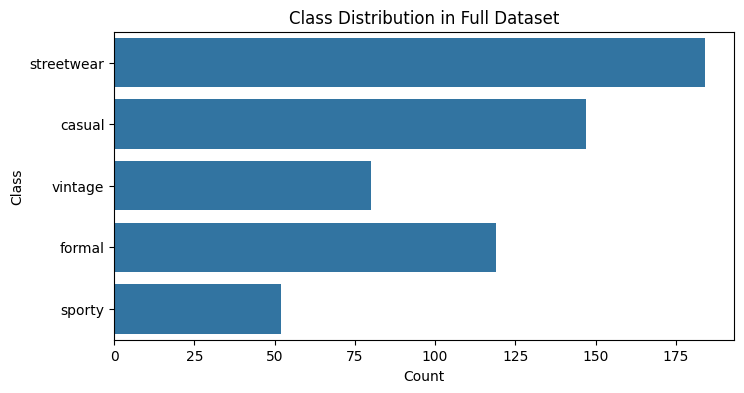

choice
streetwear    184
casual        147
formal        119
vintage        80
sporty         52
Name: count, dtype: int64


In [45]:
# Print class distribution and visualize class balance
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(y=df_full['choice'])
plt.title('Class Distribution in Full Dataset')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()
print(df_full['choice'].value_counts())

In [46]:
# Remove rows with missing image files from the full dataset
def file_exists(row):
    return os.path.exists(row['image'])  # image path is already fixed above

df_full = df_full[df_full.apply(file_exists, axis=1)].reset_index(drop=True)
print(f"Sample size after removing missing files: {len(df_full)}")

Sample size after removing missing files: 583


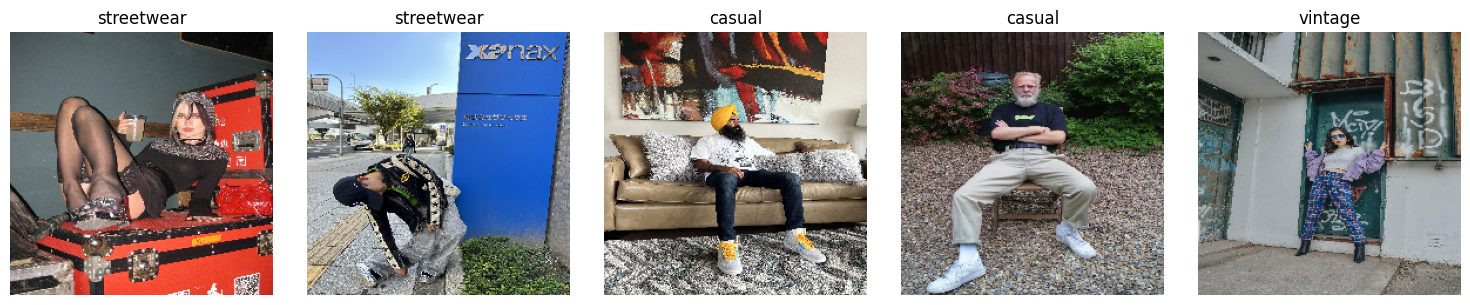

In [47]:
# Load, preprocess, and visualize a few sample images from the full dataset
img_size = (224, 224)

if df_full.empty:
    print("No images to display after filtering missing files.")
else:
    fig, axes = plt.subplots(1, min(5, len(df_full)), figsize=(15, 3))
    for i, (idx, row) in enumerate(df_full.head(5).iterrows()):
        img_path = row['image']  # path is already fixed
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=img_size)
            img_arr = img_to_array(img) / 255.0
            axes[i].imshow(img_arr)
            axes[i].set_title(row['choice'])
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [48]:
# Encode labels and split the full data into train and test sets
from sklearn.preprocessing import LabelEncoder

# Remove classes with fewer than 2 samples to avoid stratified split errors
class_counts = df_full['choice'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df_full_filtered = df_full[df_full['choice'].isin(valid_classes)].reset_index(drop=True)

if df_full_filtered.empty:
    print("No valid classes with at least 2 samples. Please check your dataset.")
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    le = LabelEncoder()
else:
    le = LabelEncoder()
    df_full_filtered['label'] = le.fit_transform(df_full_filtered['choice'])
    train_df, test_df = train_test_split(df_full_filtered, test_size=0.3, stratify=df_full_filtered['label'], random_state=42)
    print('Train size:', len(train_df), 'Test size:', len(test_df))
    print('Classes:', le.classes_)

Train size: 407 Test size: 175
Classes: ['casual' 'formal' 'sporty' 'streetwear' 'vintage']


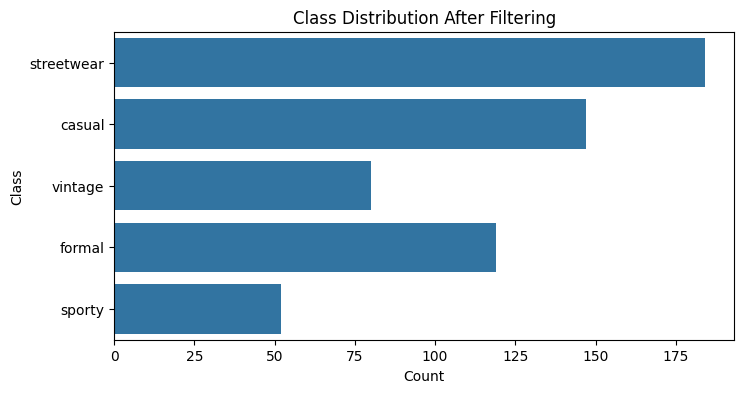

choice
streetwear    184
casual        147
formal        119
vintage        80
sporty         52
Name: count, dtype: int64
Class weights: {0: 0.7918367346938775, 1: 0.9781512605042016, 2: 2.2384615384615385, 3: 0.6326086956521739, 4: 1.455}


In [49]:
# Visualize class distribution after filtering and compute class weights
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

if not df_full_filtered.empty:
    plt.figure(figsize=(8,4))
    sns.countplot(y=df_full_filtered['choice'])
    plt.title('Class Distribution After Filtering')
    plt.xlabel('Count')
    plt.ylabel('Class')
    plt.show()
    print(df_full_filtered['choice'].value_counts())

    # Compute class weights for imbalanced classes
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df_full_filtered['label']), y=df_full_filtered['label'])
    class_weights_dict = {i : w for i, w in enumerate(class_weights)}
    print('Class weights:', class_weights_dict)
else:
    class_weights_dict = None

In [50]:
# Create data generators for training and testing with advanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.6,1.4],
    shear_range=0.2,
    channel_shift_range=30.0,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

def dataframe_to_generator(df, datagen, batch_size=4):
    if df.empty or 'image' not in df.columns or 'label' not in df.columns:
        return None
    paths = df['image'].values
    labels = df['label'].values
    imgs = []
    valid_labels = []
    for p, label in zip(paths, labels):
        try:
            img = img_to_array(load_img(p, target_size=img_size))
            imgs.append(img)
            valid_labels.append(label)
        except Exception as e:
            print(f"Warning: Could not load image {p}: {e}")
    if not imgs:
        return None
    imgs = np.array(imgs)
    return datagen.flow(imgs, to_categorical(valid_labels, num_classes=len(le.classes_)), batch_size=batch_size)

train_gen = dataframe_to_generator(train_df, train_datagen) if not train_df.empty else None
test_gen = dataframe_to_generator(test_df, test_datagen) if not test_df.empty else None

In [51]:
# Build a transfer learning model using MobileNetV2 with fine-tuning and callbacks for better accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

if train_gen is None or test_gen is None or train_df.empty or test_df.empty:
    print("No data available for training or testing. Please check your dataset and preprocessing steps.")
    model = None
else:
    # Clear any previous session to avoid clutter from old models/layers
    tf.keras.backend.clear_session()

    # Use MobileNetV2 as the base model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model layers for initial training

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(len(le.classes_), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Callbacks for early stopping, best model saving, and learning rate reduction
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    # Train initial model with class weights if available
    steps_per_epoch = max(1, len(train_df) // 4)
    validation_steps = max(1, len(test_df) // 4)
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=30,
        validation_data=test_gen,
        validation_steps=validation_steps,
        callbacks=[early_stop, checkpoint, reduce_lr],
        class_weight=class_weights_dict if class_weights_dict is not None else None
    )

    # Unfreeze more layers for fine-tuning (e.g., last 50 layers)
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    # Re-compile with lower learning rate for fine-tuning
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    # Fine-tune the model
    history_finetune = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=15,
        validation_data=test_gen,
        validation_steps=validation_steps,
        callbacks=[early_stop, checkpoint, reduce_lr],
        class_weight=class_weights_dict if class_weights_dict is not None else None
    )

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30


b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1597 - loss: 1.8081

101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.1596 - loss: 1.8078 - val_accuracy: 0.1047 - val_loss: 1.7436 - learning_rate: 5.0000e-04
Epoch 2/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.0000e+00 - loss: 2.2830

b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0000e+00 - loss: 2.2830 - val_accuracy: 0.1337 - val_loss: 1.7477 - learning_rate: 5.0000e-04
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2086 - loss: 1.7404

101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.2083 - loss: 1.7408 - val_accuracy: 0.0930 - val_loss: 1.6999 - learning_rate: 5.0000e-04
Epoch 4/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.0000e+00 - loss: 1.5145

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0000e+00 - loss: 1.5145 - val_accuracy: 0.1919 - val_loss: 1.6680 - learning_rate: 5.0000e-04
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2052 - loss: 1.7265

101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.2051 - loss: 1.7261 - val_accuracy: 0.3198 - val_loss: 1.6272 - learning_rate: 5.0000e-04
Epoch 6/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2500 - loss: 1.5008

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2500 - loss: 1.5008 - val_accuracy: 0.3140 - val_loss: 1.5975 - learning_rate: 5.0000e-04
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.1784 - loss: 1.7092 - val_accuracy: 0.2442 - val_loss: 1.6107 - learning_rate: 5.0000e-04
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2500 - loss: 1.6307 - val_accuracy: 0.1977 - val_loss: 1.6231 - learning_rate: 5.0000e-04
Epoch 9/30
100/101 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1768 - loss: 1.6194
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.1770 - loss: 1.6208 - val_accuracy: 0.0872 - val_loss: 1.8069 - learning_rate: 5.0000e-04
Epoch 10/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0000e+00 - loss: 1.7393 - val_accuracy: 0.0930 - val_loss: 1.7976 - learning_rate: 2.5000e-04
Epoch 11/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.2

101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.2983 - loss: 1.7241 - val_accuracy: 0.3605 - val_loss: 1.5808 - learning_rate: 1.0000e-05
Epoch 2/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0000e+00 - loss: 2.0404 - val_accuracy: 0.3605 - val_loss: 1.5863 - learning_rate: 1.0000e-05
Epoch 3/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1717 - loss: 1.7119

101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.1719 - loss: 1.7113 - val_accuracy: 0.3140 - val_loss: 1.5781 - learning_rate: 1.0000e-05
Epoch 4/15
  1/101 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7500 - loss: 1.3372

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7500 - loss: 1.3372 - val_accuracy: 0.3081 - val_loss: 1.5776 - learning_rate: 1.0000e-05
Epoch 5/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2077 - loss: 1.6177

101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.2079 - loss: 1.6176 - val_accuracy: 0.2326 - val_loss: 1.5742 - learning_rate: 1.0000e-05
Epoch 6/15
  1/101 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.2500 - loss: 1.1557

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2500 - loss: 1.1557 - val_accuracy: 0.2384 - val_loss: 1.5712 - learning_rate: 1.0000e-05
Epoch 7/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2040 - loss: 1.6651

101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.2042 - loss: 1.6644 - val_accuracy: 0.2209 - val_loss: 1.5680 - learning_rate: 1.0000e-05
Epoch 8/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7500 - loss: 1.6682 - val_accuracy: 0.2267 - val_loss: 1.5681 - learning_rate: 1.0000e-05
Epoch 9/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2582 - loss: 1.6050

101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.2578 - loss: 1.6052 - val_accuracy: 0.2209 - val_loss: 1.5614 - learning_rate: 1.0000e-05
Epoch 10/15
  1/101 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.0000e+00 - loss: 1.8448

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0000e+00 - loss: 1.8448 - val_accuracy: 0.2267 - val_loss: 1.5604 - learning_rate: 1.0000e-05
Epoch 11/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2428 - loss: 1.5524

101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.2427 - loss: 1.5529 - val_accuracy: 0.3140 - val_loss: 1.5493 - learning_rate: 1.0000e-05
Epoch 12/15
  1/101 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.2500 - loss: 1.3826

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2500 - loss: 1.3826 - val_accuracy: 0.3198 - val_loss: 1.5480 - learning_rate: 1.0000e-05
Epoch 13/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.2016 - loss: 1.5538 - val_accuracy: 0.2791 - val_loss: 1.5487 - learning_rate: 1.0000e-05
Epoch 14/15
  1/101 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.2500 - loss: 1.0846

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2500 - loss: 1.0846 - val_accuracy: 0.2849 - val_loss: 1.5472 - learning_rate: 1.0000e-05
Epoch 15/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.2213 - loss: 1.5715 - val_accuracy: 0.2500 - val_loss: 1.5493 - learning_rate: 1.0000e-05


In [52]:
# Train the model on the sample data
if train_gen is None or test_gen is None:
    print("No data available for training or testing. Please check your dataset and preprocessing steps.")
else:
    steps_per_epoch = max(1, len(train_df) // 4)
    validation_steps = max(1, len(test_df) // 4)
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=5,
        validation_data=test_gen,
        validation_steps=validation_steps
    )

Epoch 1/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.2872 - loss: 1.5909 - val_accuracy: 0.2791 - val_loss: 1.5551
Epoch 2/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2500 - loss: 1.6229 - val_accuracy: 0.2733 - val_loss: 1.5598
Epoch 3/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.3628 - loss: 1.4995 - val_accuracy: 0.2674 - val_loss: 1.5678
Epoch 4/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2500 - loss: 1.4769 - val_accuracy: 0.2733 - val_loss: 1.5677
Epoch 5/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.3161 - loss: 1.5005 - val_accuracy: 0.2907 - val_loss: 1.5890


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


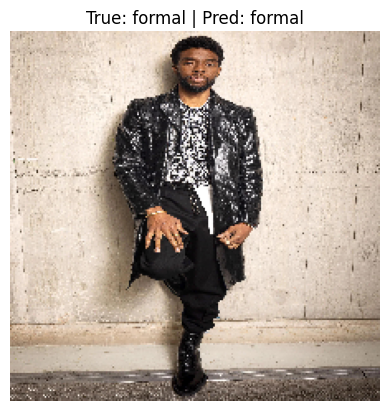

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


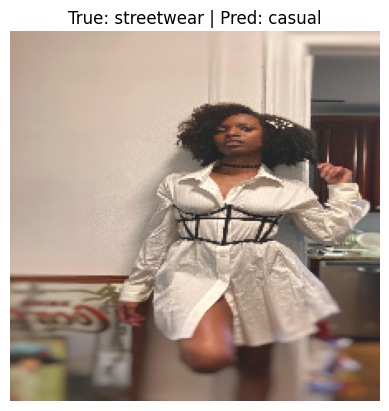

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


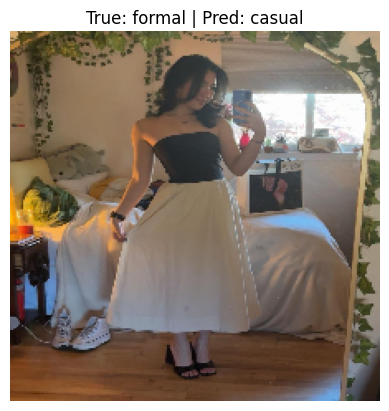

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


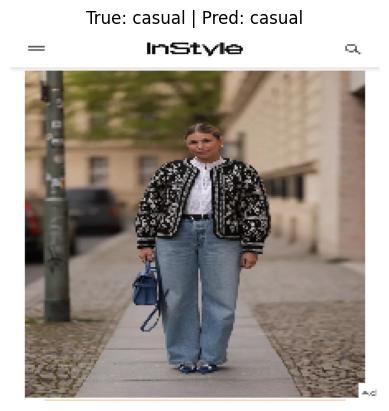

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


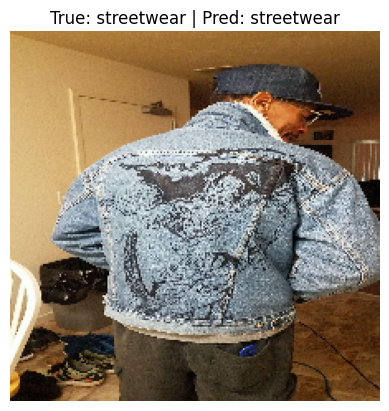

In [53]:
# Evaluate the model and show predictions on a few test images
import random

if test_df.empty or 'model' not in globals():
    print("No test data or model not defined. Please check previous steps.")
else:
    test_imgs = test_df.sample(n=min(5, len(test_df)), random_state=42)
    for idx, row in test_imgs.iterrows():
        img_path = row['image']  # path is already correct
        try:
            img = load_img(img_path, target_size=img_size)
            img_arr = img_to_array(img) / 255.0
            pred = model.predict(np.expand_dims(img_arr, axis=0))
            pred_label = le.inverse_transform([np.argmax(pred)])[0]
            plt.imshow(img_arr)
            plt.title(f"True: {row['choice']} | Pred: {pred_label}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Warning: Could not load image {img_path}: {e}")